In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import re
import pandas as pd
from keras.src.preprocessing.image import ImageDataGenerator

tf.config.list_physical_devices('GPU')

2024-04-23 20:01:00.293442: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 20:01:00.315002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 20:01:00.315021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 20:01:00.315655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 20:01:00.319421: I tensorflow/core/platform/cpu_feature_guar

[]

# Traffic Sign Classification
I have chosen to pick up the traffic sign classification project.
The goal is to develop a model that can classify each traffic sign category with a high degree of accuracy.
Let's explore

In [2]:
shapes = ['diamond', 'hex', 'round', 'square', 'triangle']


def load_dataset():
    traffic_sign_dict = {
        'path': [],
        'shape': [],
        'type': [],
        'img': []
    }

    cols = list(traffic_sign_dict.keys())

    for shape in shapes:
        print(f'Loading {shape}...')
        path = os.path.join('dataset', f'{shape}/')

        for img_path in glob(f'{path}/**/*.png', recursive=True):
            # get list of dirs in path
            dirs = re.findall('([a-zA-Z]+)', img_path)
            # sign type is the 3rd element
            sign_type = dirs[2]
            img = Image.open(img_path)

            traffic_sign_dict['path'].append(img_path)
            traffic_sign_dict['shape'].append(shape)
            traffic_sign_dict['type'].append(sign_type)
            traffic_sign_dict['img'].append(np.asarray(img))

        print(f'{shape} images loaded')

    return pd.DataFrame(traffic_sign_dict, columns=cols)


In [3]:
traffic_df = load_dataset()

Loading diamond...
diamond images loaded
Loading hex...
hex images loaded
Loading round...
round images loaded
Loading square...
square images loaded
Loading triangle...
triangle images loaded


In [4]:
traffic_df.head()

,path,shape,type,img
0,dataset/diamond/rightofway/01504_00000.png,diamond,rightofway,"[[36, 36, 29, 26, 29, 36, 29, 40, 36, 38, 30, ..."
1,dataset/diamond/rightofway/00927_00000.png,diamond,rightofway,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,dataset/diamond/rightofway/00065_00000.png,diamond,rightofway,"[[84, 88, 89, 89, 89, 84, 73, 74, 72, 71, 79, ..."
3,dataset/diamond/rightofway/01275_00001.png,diamond,rightofway,"[[46, 50, 62, 79, 86, 95, 106, 99, 101, 100, 1..."
4,dataset/diamond/rightofway/01569_00001.png,diamond,rightofway,"[[43, 47, 41, 44, 41, 41, 42, 43, 43, 43, 45, ..."


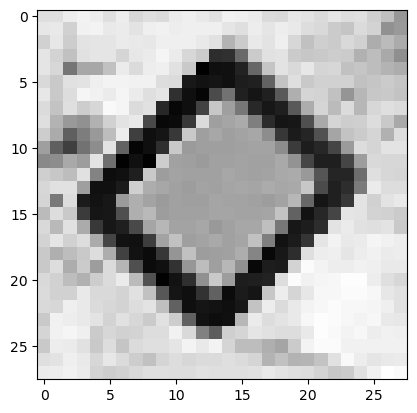

In [5]:
plt.imshow(traffic_df['img'].iloc[0], cmap='binary')

In [6]:
print(len(traffic_df['img'].iloc[0].shape))
traffic_df['img'].iloc[0].shape

2


(28, 28)

In [7]:
sign_types = traffic_df['type'].unique()
sign_types

array(['rightofway', 'stop', 'limitedtraffic', 'noentry', 'bicycle',
       'roundabout', 'speed', 'traveldirection', 'trafficdirective',
       'noparking', 'laneend', 'parking', 'continue', 'crossing',
       'warning', 'giveway'], dtype=object)

Observations:
* Images are 28x28 dims
* No colour channels

Exploring the classes:

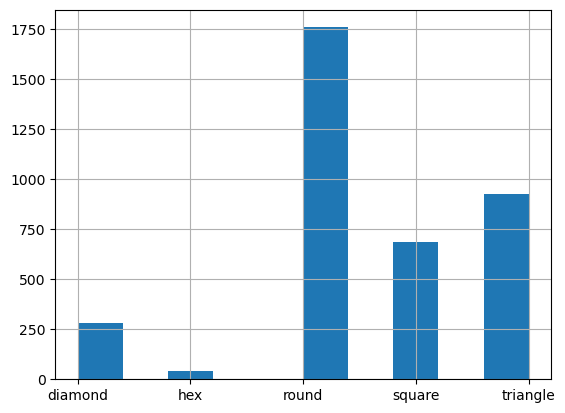

shape
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64

In [8]:
traffic_df['shape'].hist()
plt.show()
traffic_df['shape'].value_counts()

In [9]:
(traffic_df['shape'].value_counts() / len(traffic_df['shape'])) * 100

shape
round       47.580427
triangle    25.033793
square      18.599622
diamond      7.623682
hex          1.162476
Name: count, dtype: float64

Observations:
* Large class imbalance
* Round shapes make up 47.58% of all instances
* Triangle is 25.03%
* Square is 18.6%
* Diamond is 7.62%
* Hex 1.16%

The imbalance of shapes will affect the accuracy of the model. We'll need to use a performance metric that accounts for the class imbalances.

Let's explore the types:

In [10]:
def print_value_counts_and_type_hist(shape):
    shape_types = traffic_df.query(f'shape == "{shape}"')['type']
    shape_types.value_counts(ascending=True).plot(kind='bar')
    print(shape_types.value_counts())
    print(f'Proportionate to {shape}')
    print(shape_types.value_counts() / len(shape_types) * 100)
    print(f'Proportionate to dataset')
    print(shape_types.value_counts() / len(traffic_df) * 100)


type
rightofway    282
Name: count, dtype: int64
Proportionate to diamond
type
rightofway    100.0
Name: count, dtype: float64
Proportionate to dataset
type
rightofway    7.623682
Name: count, dtype: float64


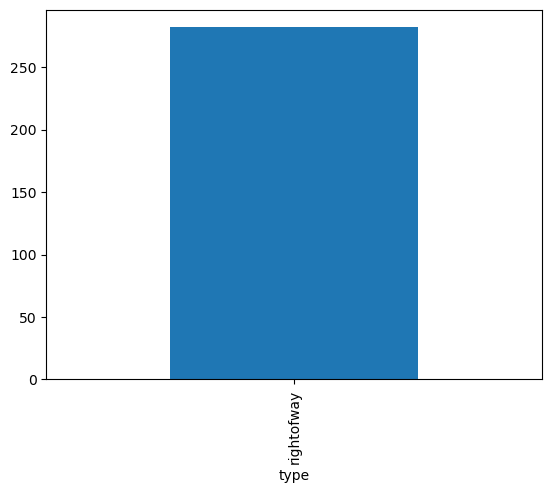

In [11]:
print_value_counts_and_type_hist('diamond')

Observations:
* Only one sign type for Diamond which is Right of Way
    * In reality, there are many different types of diamond traffic signs around the world
    * They are not just for right of way
        * E.g. in Australia we use them for general warnings about the road: animal crossings, road hazards, etc.
    * A model trained only on this dataset is unlikely to have good results

type
noentry             375
speed               316
bicycle             285
noparking           242
trafficdirective    195
limitedtraffic      125
traveldirection     124
roundabout           98
Name: count, dtype: int64
Proportionate to round
type
noentry             21.306818
speed               17.954545
bicycle             16.193182
noparking           13.750000
trafficdirective    11.079545
limitedtraffic       7.102273
traveldirection      7.045455
roundabout           5.568182
Name: count, dtype: float64
Proportionate to dataset
type
noentry             10.137875
speed                8.542849
bicycle              7.704785
noparking            6.542309
trafficdirective     5.271695
limitedtraffic       3.379292
traveldirection      3.352257
roundabout           2.649365
Name: count, dtype: float64


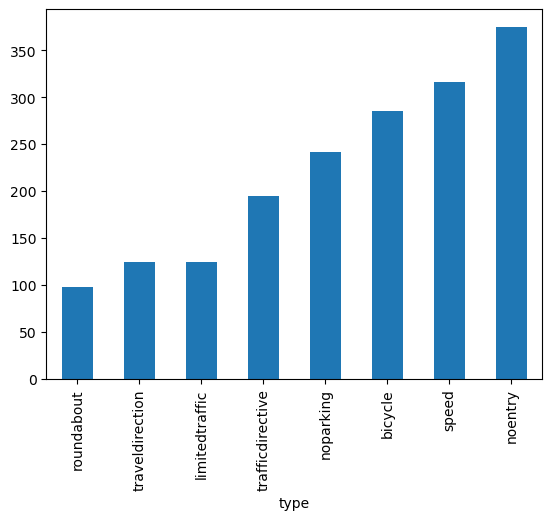

In [12]:
print_value_counts_and_type_hist('round')

Observations:
* Types of Round signs are distributed evenly, with only 3 round types comprising less than 10% of the dataset
* Similar to the overall dataset, it'll be prudent to use a performance metric that can accont for these imbalances
* No entry type makes up 10% of the overall dataset

type
parking     276
continue    199
laneend     118
crossing     95
Name: count, dtype: int64
Proportionate to square
type
parking     40.116279
continue    28.924419
laneend     17.151163
crossing    13.808140
Name: count, dtype: float64
Proportionate to dataset
type
parking     7.461476
continue    5.379832
laneend     3.190051
crossing    2.568262
Name: count, dtype: float64


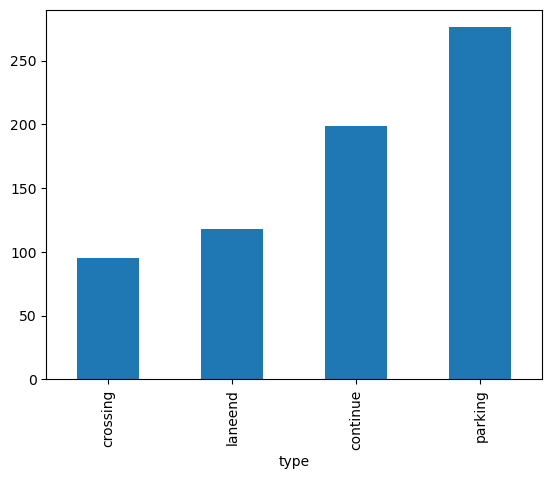

In [13]:
print_value_counts_and_type_hist('square')

Observations:
* Parking signs make up the majority of the square signs - 40.11%
* Continue makes up 28.92%
* Lane end is 17.15%
* Crossing 13.81%
* Parking signs make up 7.45% of the dataset

type
warning    695
giveway    231
Name: count, dtype: int64
Proportionate to triangle
type
warning    75.053996
giveway    24.946004
Name: count, dtype: float64
Proportionate to dataset
type
warning    18.788862
giveway     6.244931
Name: count, dtype: float64


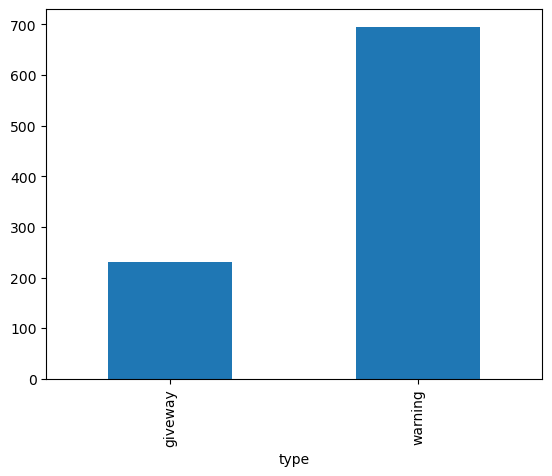

In [14]:
print_value_counts_and_type_hist('triangle')

Observations: 
* Warning is the most occuring type for triangles.

type
stop    43
Name: count, dtype: int64
Proportionate to hex
type
stop    100.0
Name: count, dtype: float64
Proportionate to dataset
type
stop    1.162476
Name: count, dtype: float64


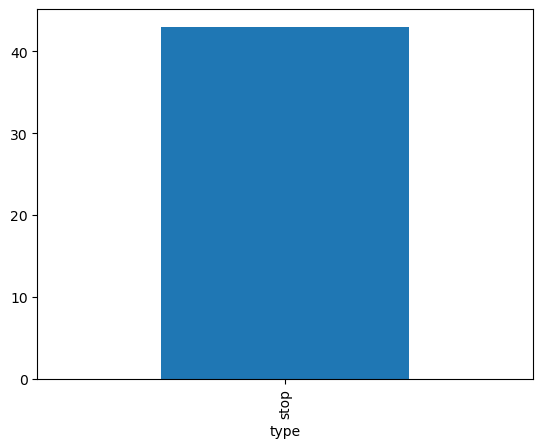

In [15]:
print_value_counts_and_type_hist('hex')

<Axes: xlabel='type'>

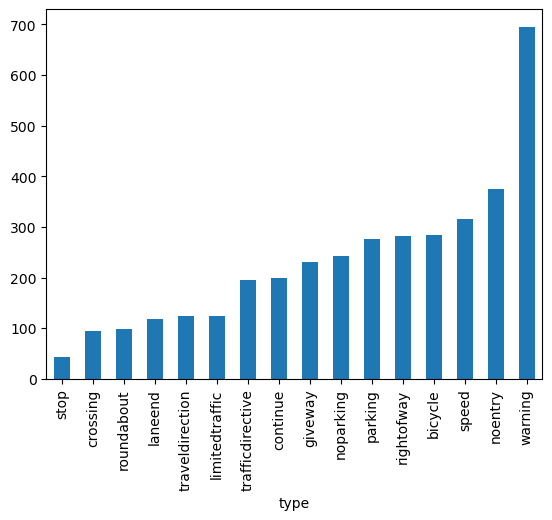

In [16]:
traffic_df['type'].value_counts(ascending=True).plot(kind='bar')

Observations:
* Warnings make up 18% of all instances in the dataset, signifcantly outclassing all other sign types

We'll now observe the images in the dataset

In [17]:
import random


def sample_n_images_rand(n=5, seed=42):
    fig, axes = plt.subplots(nrows=len(shapes), ncols=n, figsize=(14, 14))
    fig.tight_layout(h_pad=5, w_pad=5)
    row_iter = 0

    for shape in shapes:
        col_iter = 0
        for index, row in traffic_df.query(f'shape == "{shape}"').iterrows():
            axes[row_iter, col_iter].set_title(f'shape={shape}; type={row["type"]}', backgroundcolor='white')
            axes[row_iter, col_iter].set_axis_off()
            axes[row_iter, col_iter].imshow(row['img'], cmap='binary')
            col_iter += 1
        row_iter += 1

In [18]:


def sample_by_signtype(sign_type, n=5, n_rows=1, seed=0, figsize=(14, 14)):
    seed = seed if seed > 0 else random.randint(1, 999999999)
    print(f'Sampling with seed {seed}')

    df = traffic_df.query(f'type == "{sign_type}"')
    fix, ax = plt.subplots(nrows=n_rows, ncols=5, figsize=figsize)
    fix.tight_layout()

    row_iter = 0
    col_iter = 0
    for index, row in df.sample(n, random_state=seed).iterrows():
        if n_rows > 1:
            ax[row_iter, col_iter].set_title(f'{row["shape"]} - {sign_type}')
            ax[row_iter, col_iter].imshow(row['img'], cmap="binary")
        else:
            ax[col_iter].set_title(f'{row["shape"]}-{sign_type}')
            ax[col_iter].imshow(row['img'], cmap="binary")

        col_iter += 1
        if col_iter >= 5:
            col_iter = 0
            row_iter += 1


def sample_n_img_by_shape(shape, n=5, n_rows=1, seed=0, figsize=(14, 14)):
    seed = seed if seed > 0 else random.randint(1, 999999999)
    print(f'Sampling with seed {seed}')

    df = traffic_df.query(f'shape == "{shape}"')
    fix, ax = plt.subplots(nrows=n_rows, ncols=5, figsize=figsize)

    row_iter = 0
    col_iter = 0
    for index, row in df.sample(n, random_state=seed).iterrows():
        if n_rows > 1:
            ax[row_iter, col_iter].set_title(f'{shape} - {row["type"]}')
            ax[row_iter, col_iter].imshow(row['img'], cmap="binary")
        else:
            ax[col_iter].set_title(f'{shape}-{row["type"]}')
            ax[col_iter].imshow(row['img'], cmap="binary")

        col_iter += 1
        if col_iter >= 5:
            col_iter = 0
            row_iter += 1


Sampling with seed 567823565


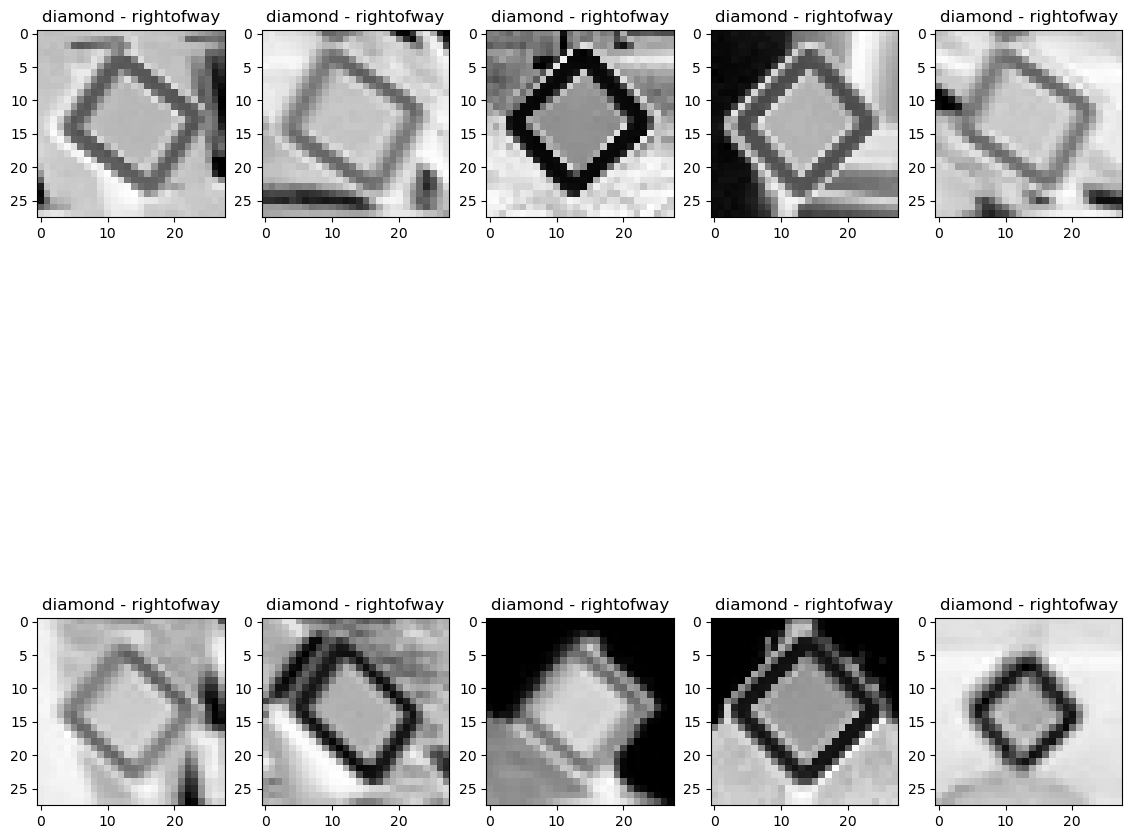

In [19]:
sample_n_img_by_shape('diamond', 10, 2)

Observations: 
* Diamond has only one type: right of way
* Right of way is characterized with a dark diamond centre, with a light-colored outline. 
* Some images have the colours inverted: light inner-diamond, dark outline
* There are blurry photos of diamonds
* Diamonds against light backgrounds, dark backgrounds
    * A variety of backgrounds is important in helping our model generalise to unseen data
    * We don't want to train a model that predicts the background afterall.   

Sampling with seed 154236194


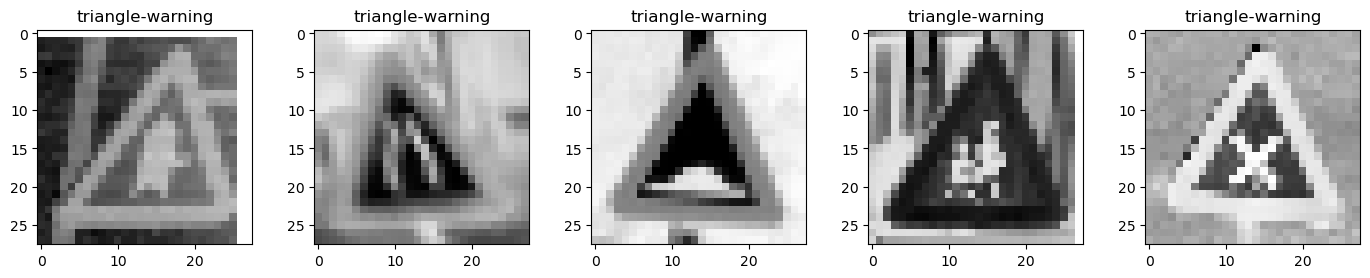

In [20]:
sample_by_signtype('warning')

Sampling with seed 775289045


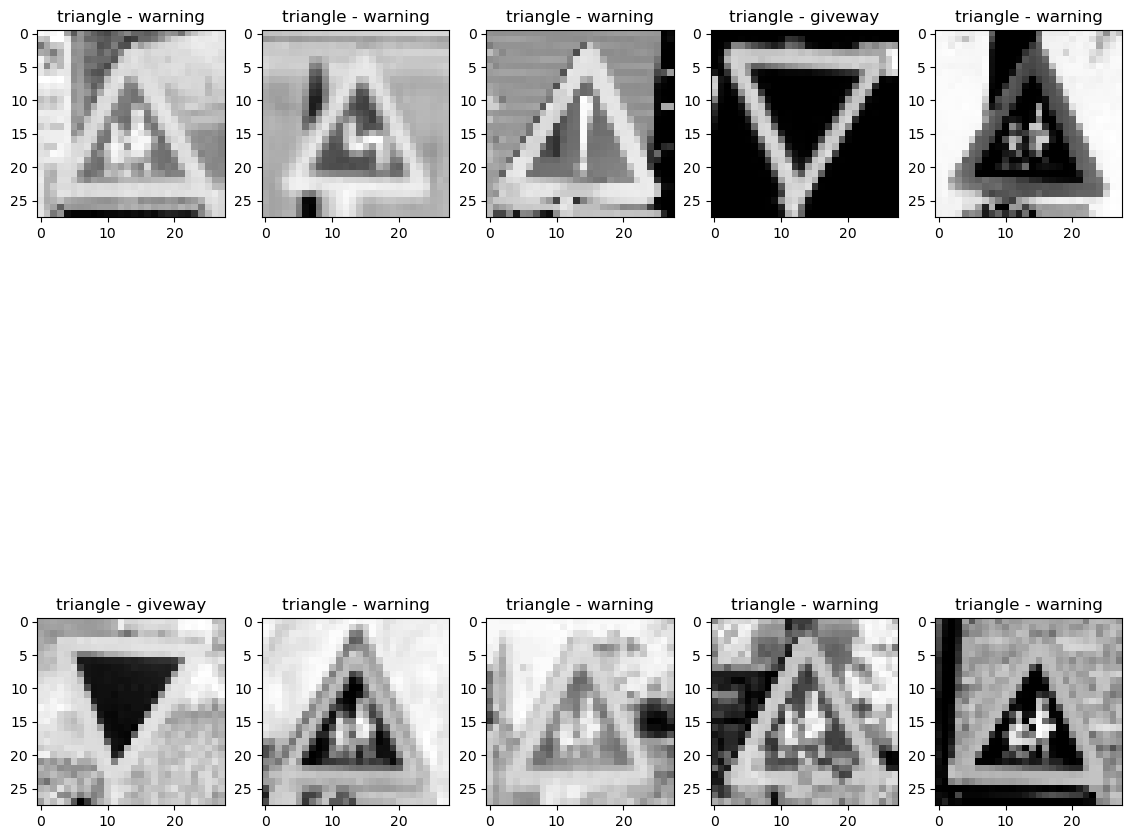

In [21]:
sample_n_img_by_shape('triangle', 10, 2)

* Giveway signs are inverted triangles
    * Giveway signs are blank always 
* Warnings typically have a symbol at the centre of them, denoting the kind of warning. 
    * These symbols include exclamation marks, crosses, and various arrows. 
* Triangle signs generally have a light-colored centre, with dark edges/outlines.   

Sampling with seed 313638817


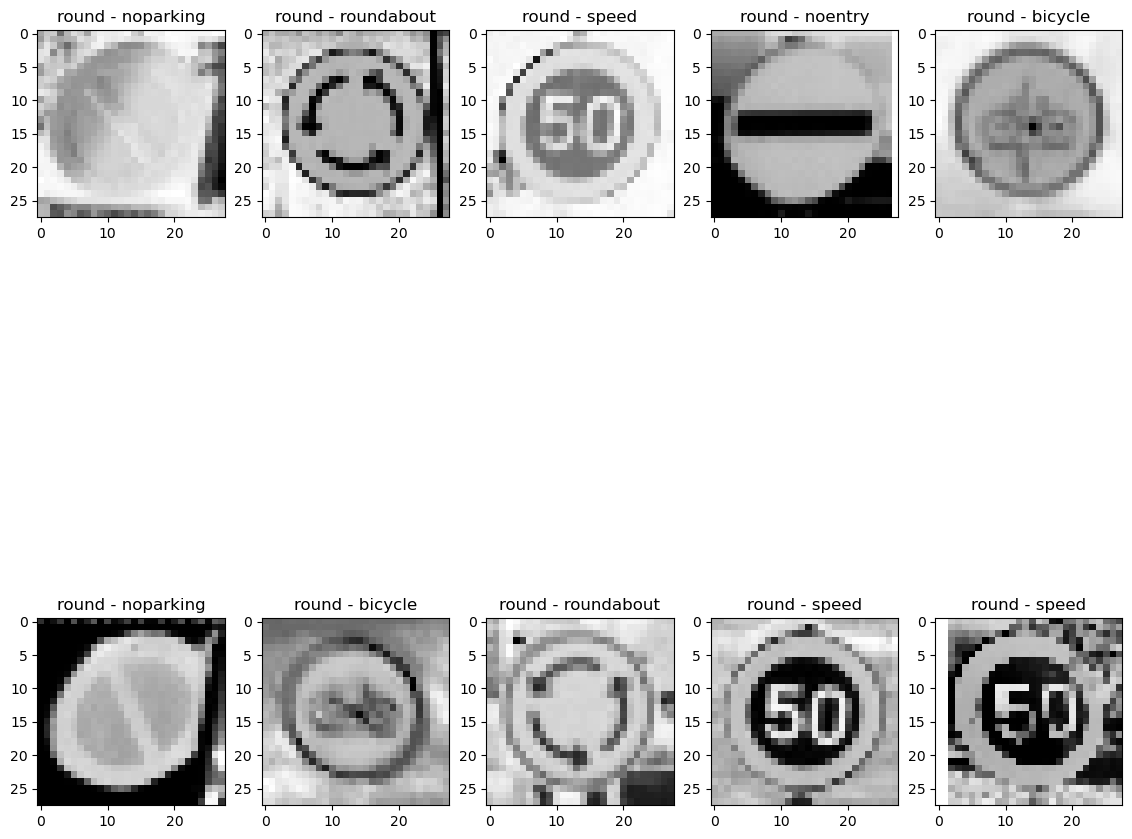

In [22]:
sample_n_img_by_shape('round', 10, 2)

Sampling with seed 468261202


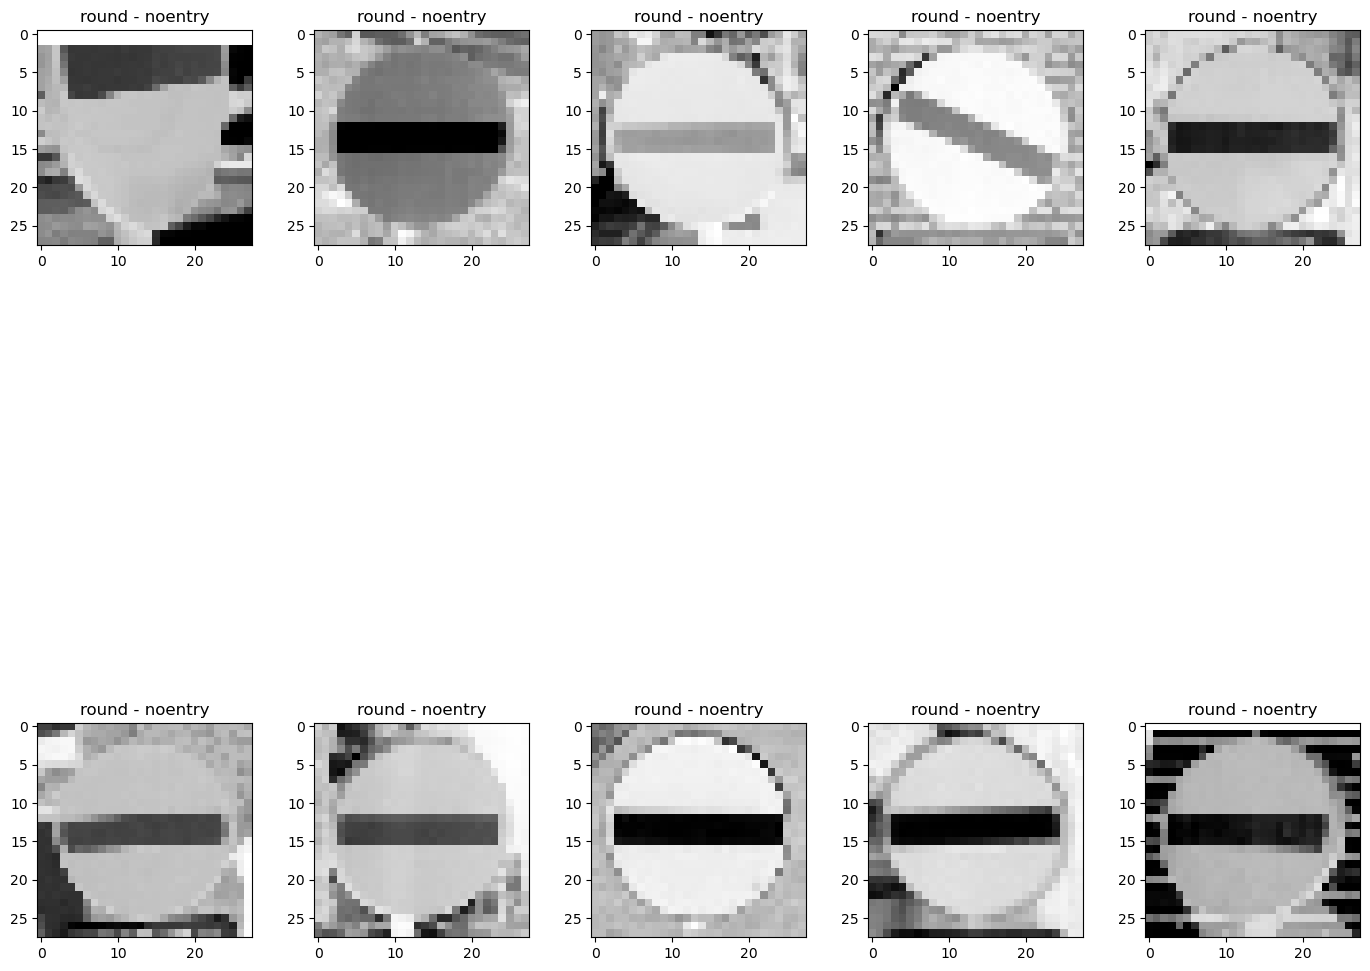

In [23]:
sample_by_signtype('noentry', 10, 2)

Sampling with seed 123028819


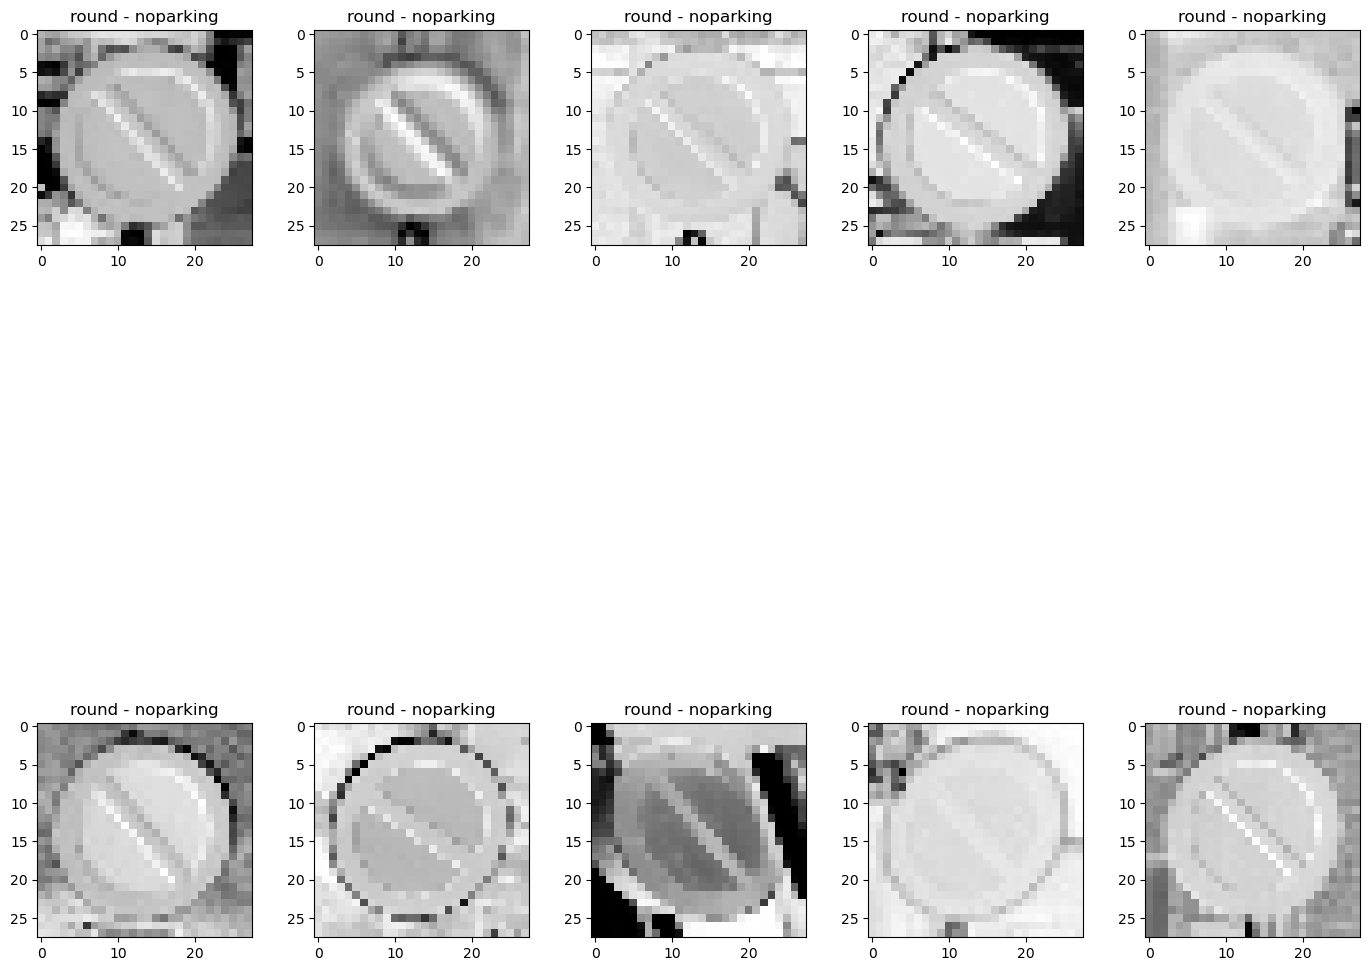

In [24]:
sample_by_signtype('noparking', 10, 2)

Sampling with seed 274799518


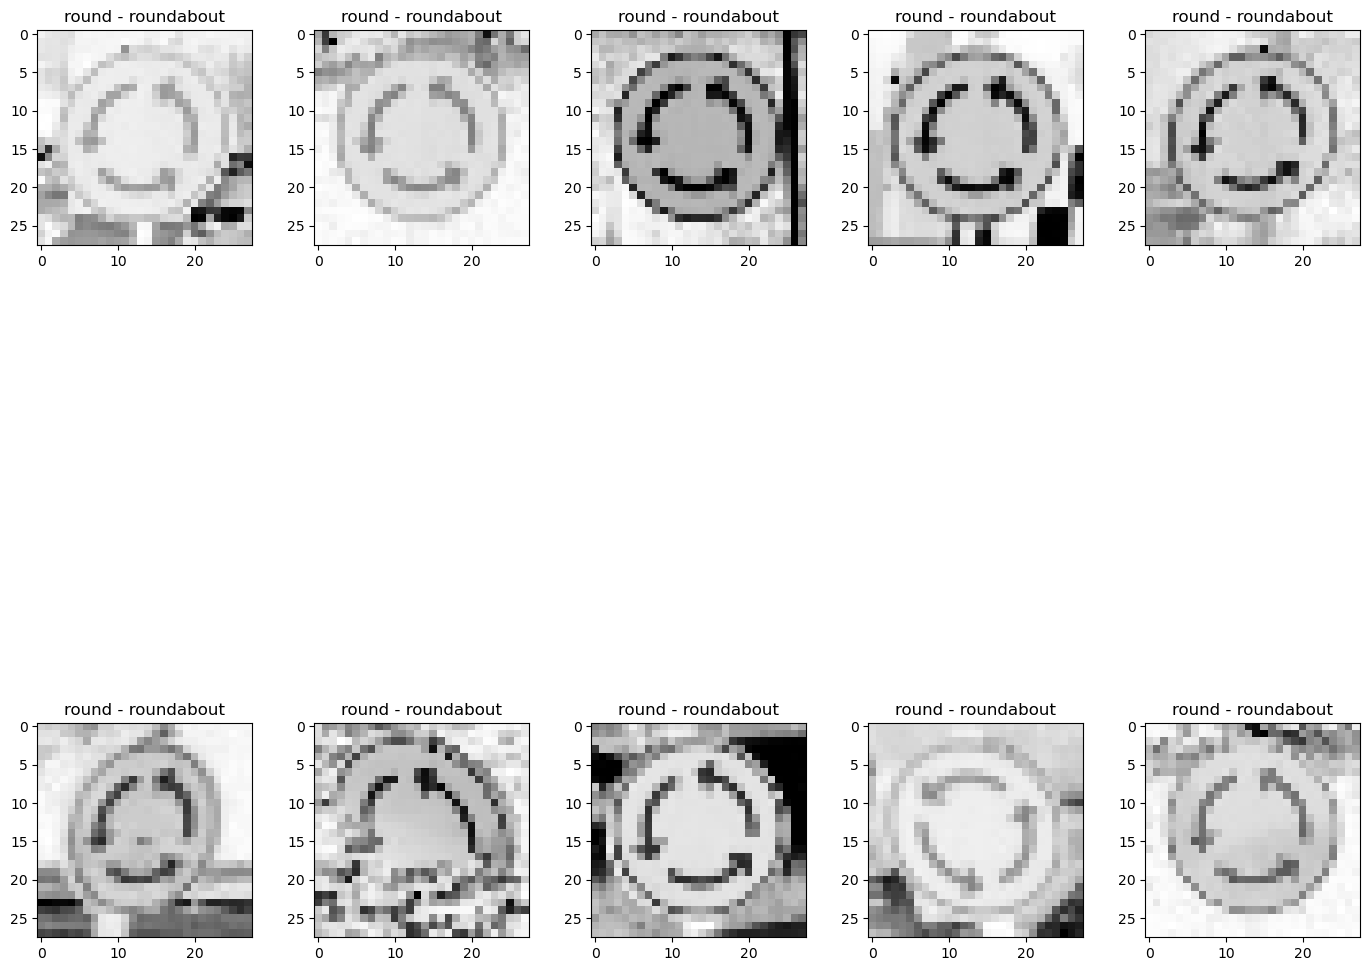

In [25]:
sample_by_signtype('roundabout', 10, 2)

Sampling with seed 856679556


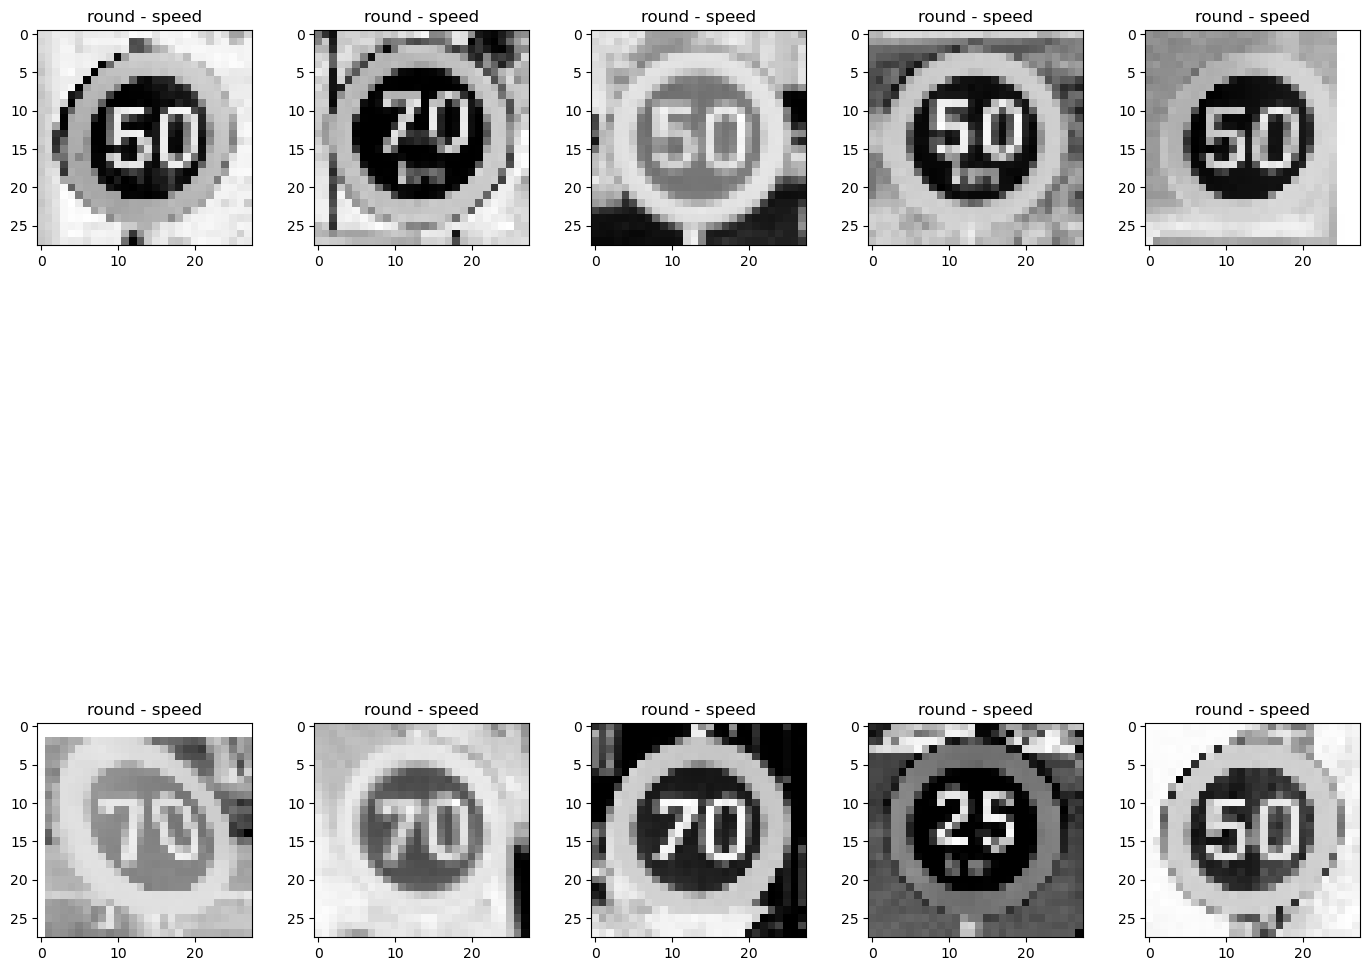

In [26]:
sample_by_signtype('speed', 10, 2)

Sampling with seed 80966381


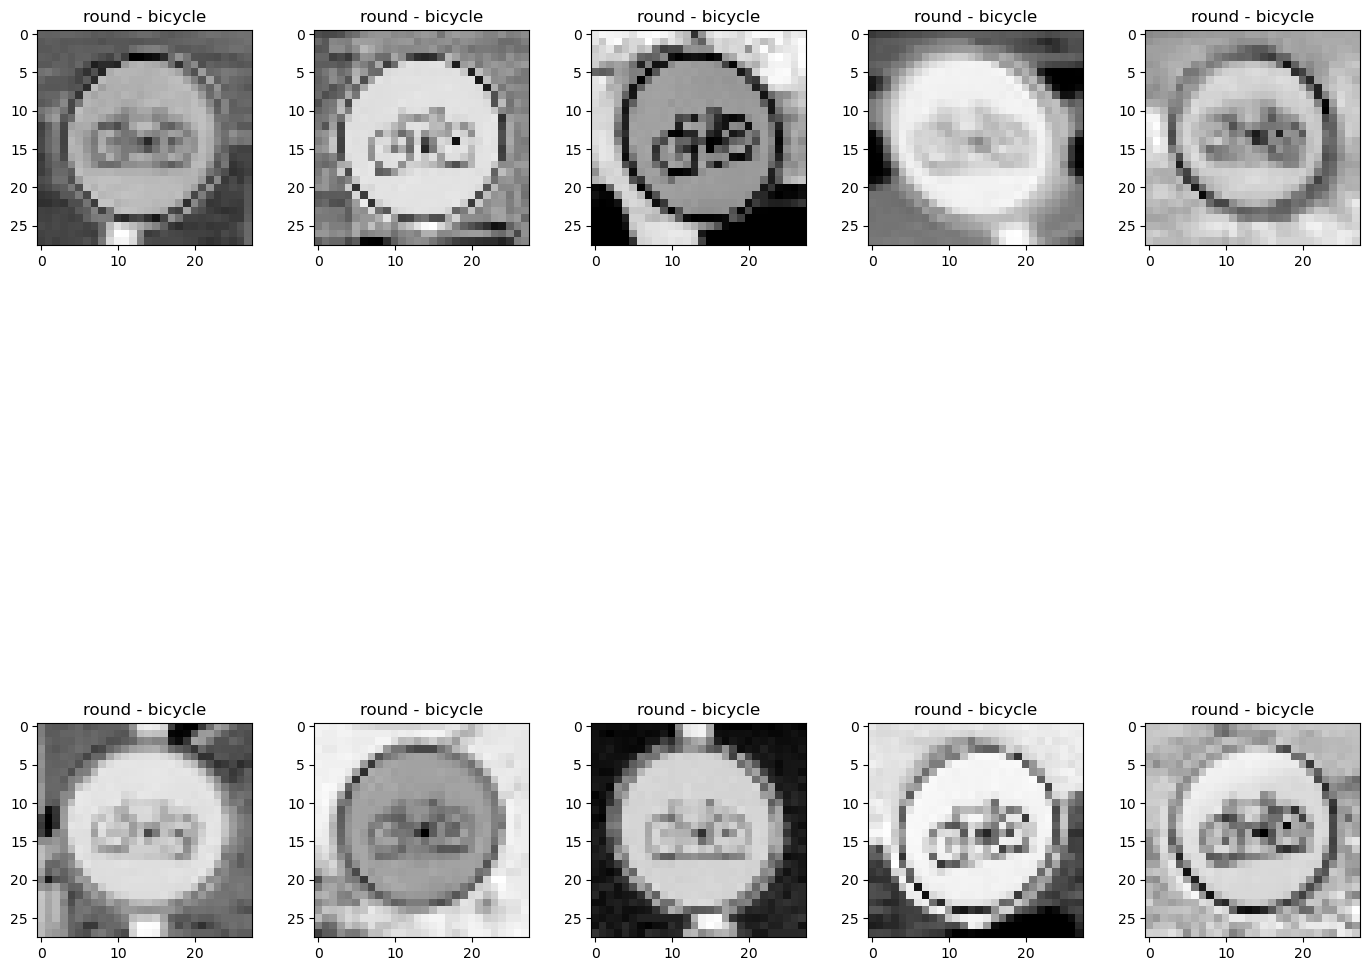

In [27]:
sample_by_signtype('bicycle', 10, 2)

Sampling with seed 468340112


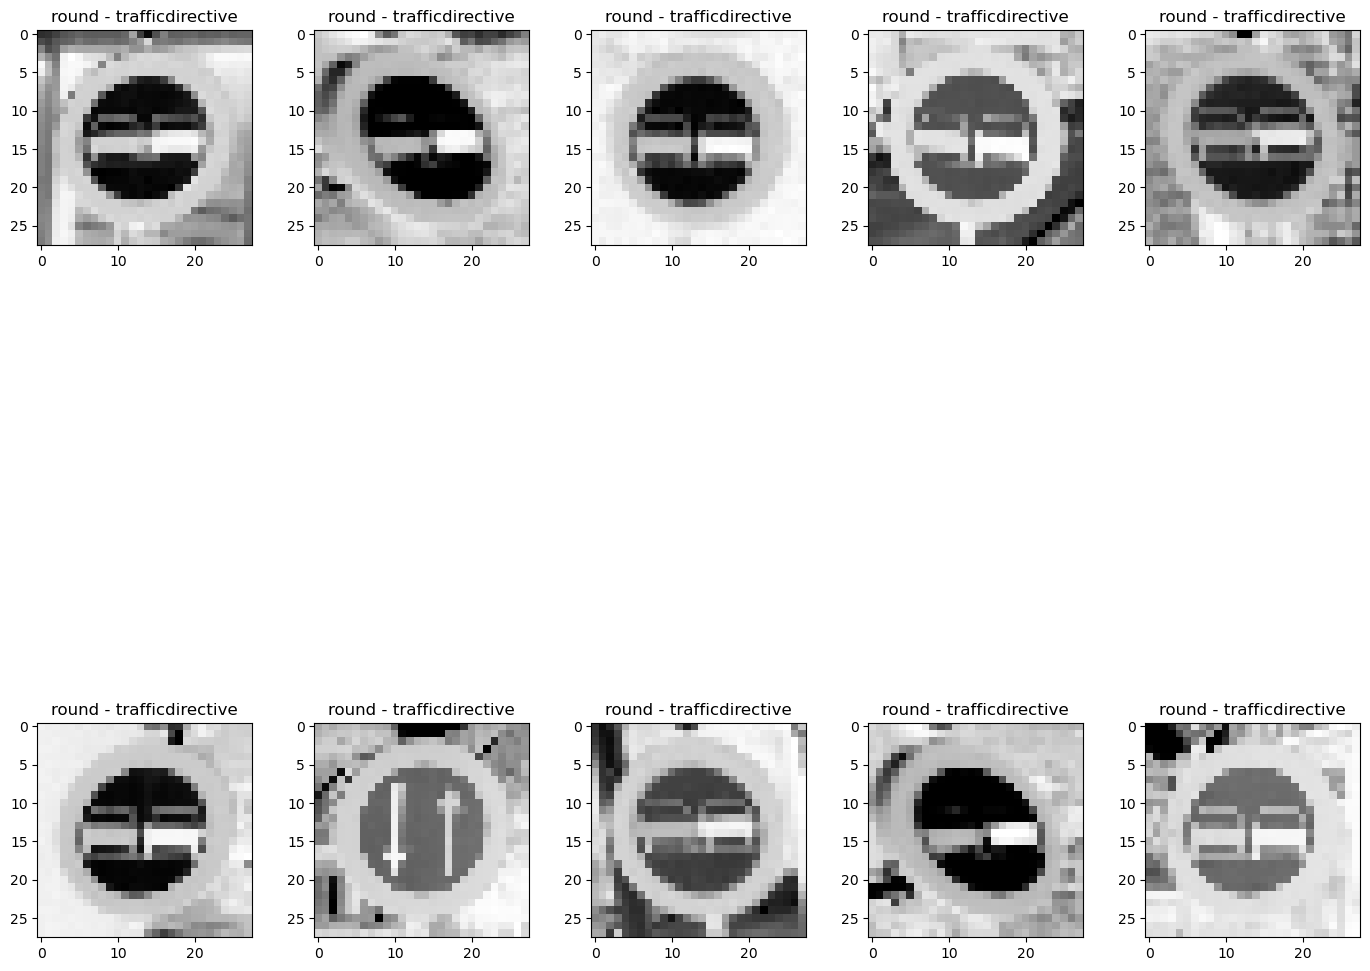

In [28]:
sample_by_signtype('trafficdirective', 10, 2)

Sampling with seed 240716665


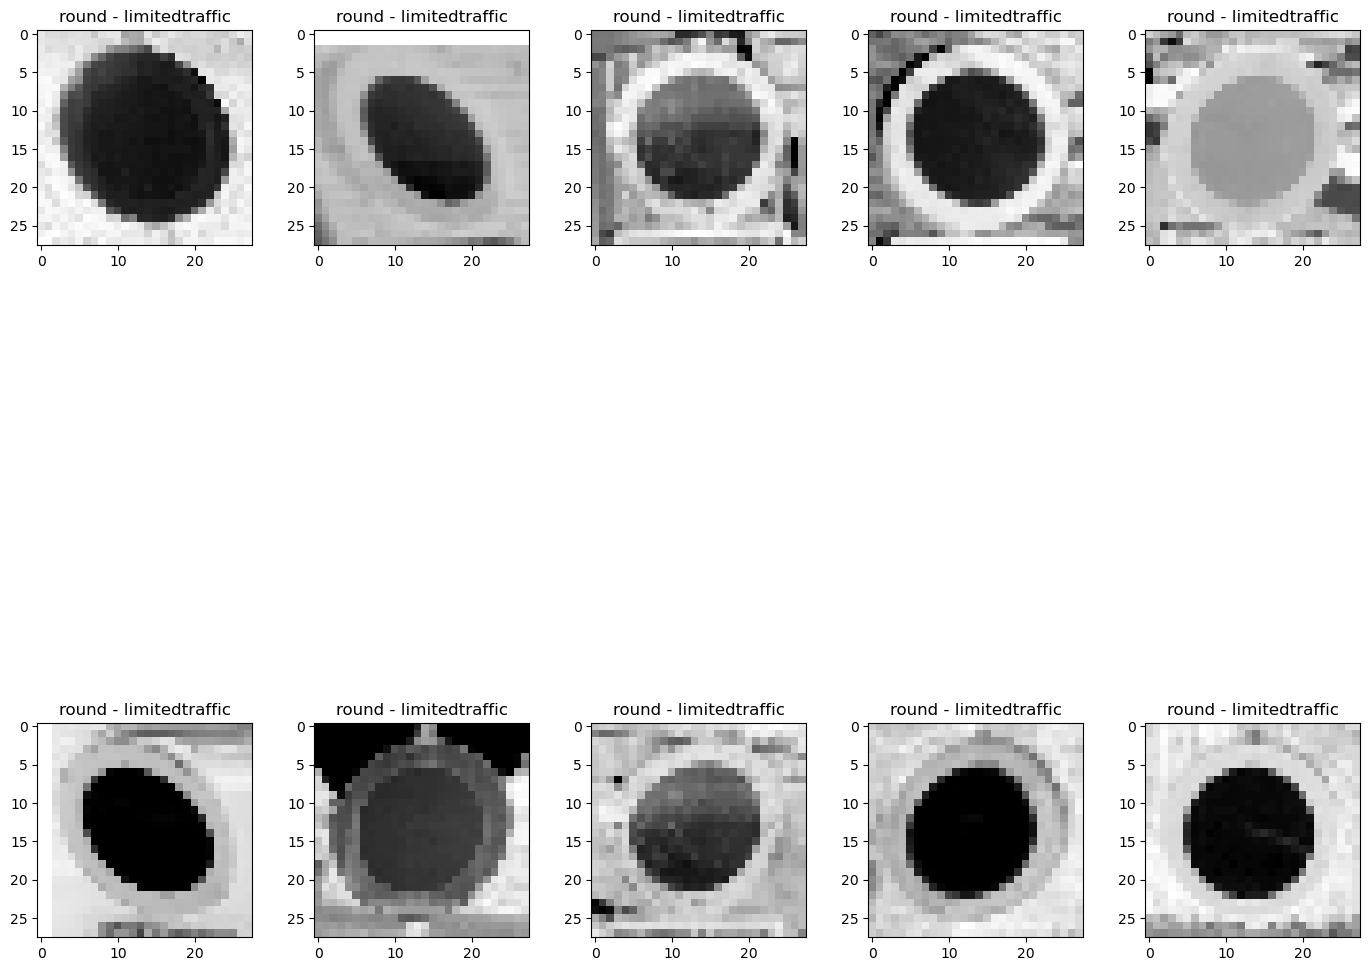

In [29]:
sample_by_signtype('limitedtraffic', 10, 2)

Observations: 
* Round signs are circular (duh)
* No parking signs are features a diagonal slash through the centre, intersecting a circle.
    * The diagonal line and the circle are typically the same color  
* Similarly, no entry signs have a thick white slash through the centre.
    * Some images of no entry also feature a white border

* Roundabouts always have 3 light-colored arrows following each other around the sign
    * Some roundabout signs have light-colored dots/squares in the centre of the arrows
    * Some roundabout signs also have white borders
* Speed signs generally have the speed limit present in the centre, against a light-colored background
    * Borders of speed signs range from light to dark
        * Light borders appear to be from the sun hitting the sign
        * The assumption made here is the borders are red, but appear gray because of the lack of color info.
* Bicycle signs feature a light-coloured bike set against a dark background (possibly red)
    * There is a white border/outline around the bike
    * Some images are taken during the day, with greater light exposure leading to lighter coloured signs
    * Some bike signs feature a solid coloured bike  
    * Some images of bicycles don't have any legible details. 
        * E.g. seed = 346561578. There is an image of a bicycle sign but the sign is not legible.
* Traffic directives feature (presumably) red borders, with various details centred. 
    * In cases there are arrows in the centre
        * These are usually two arrows - one pointing down, the other up. Possible a two-lane street sign
    * Some have two cars side by side
    * Others are similar to no entry signs - they feature the diagonal line, but this line is overlayed on various other symbols
        * This style of sign may be to indicate a certain action is not allowed - e.g. no left turn
    * There are bicycle images as well in the traffic directive sign types.
        * The inclusion of bicycle images under this sign type could impact model performance as the model sees the same images but under different features
* Limited Traffic signs are just red circles against a white centre. 


Sampling with seed 927327369


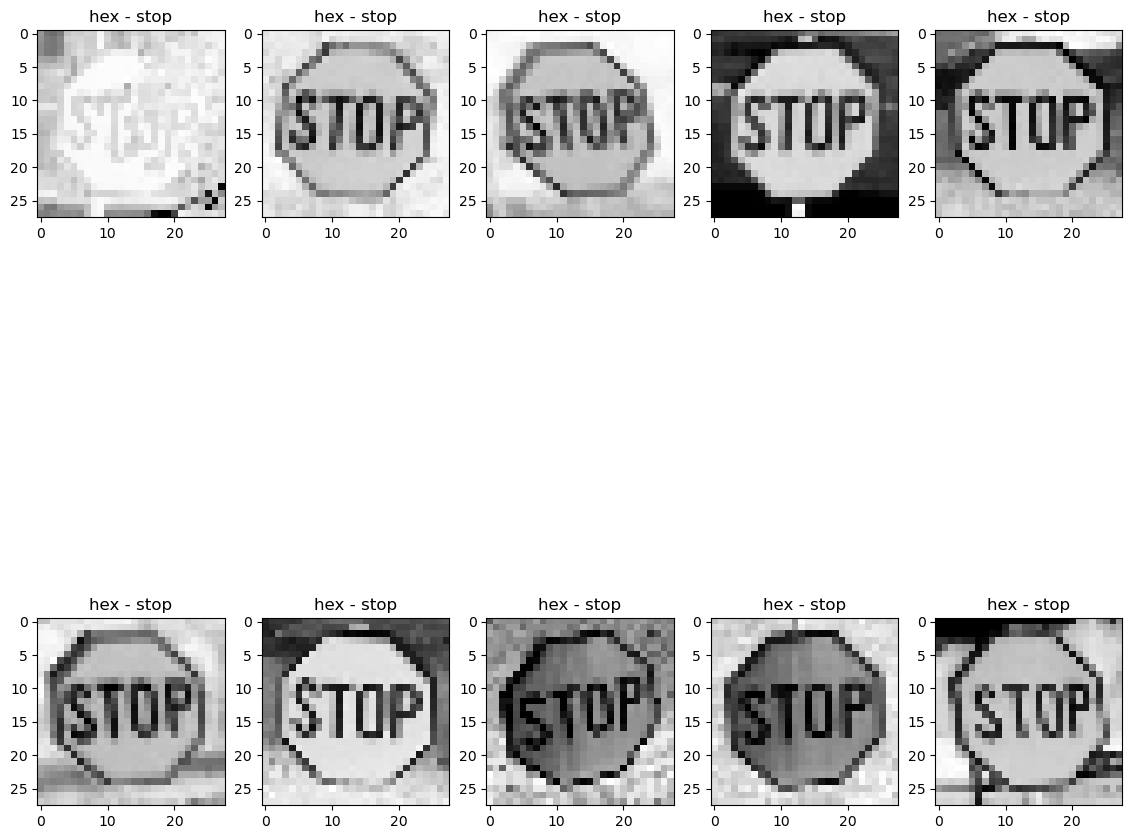

In [30]:
sample_n_img_by_shape('hex', 10, 2)

Observations: 
* All Hex signs are stop signs
 * Stop signs feature the word "STOP" in bold white letters against a red background, with a white outline

Sampling with seed 818606784


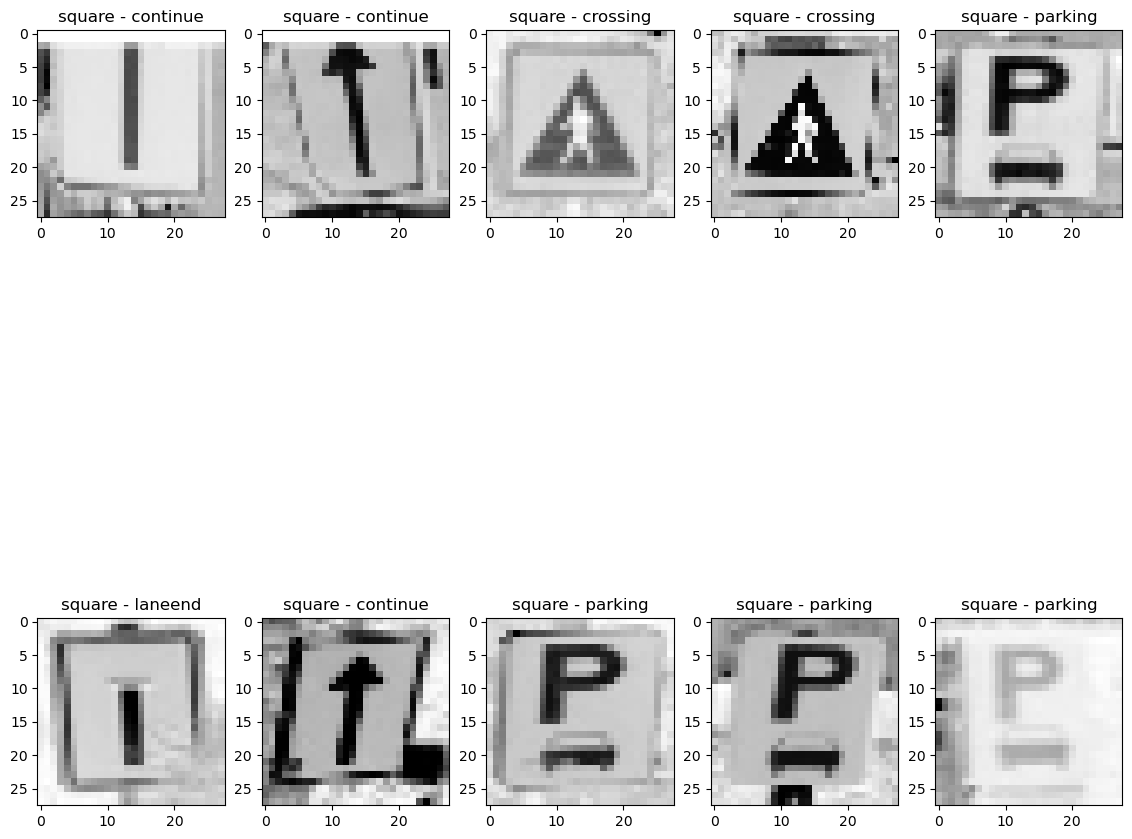

In [31]:
sample_n_img_by_shape('square', 10, 2)

Sampling with seed 183219763


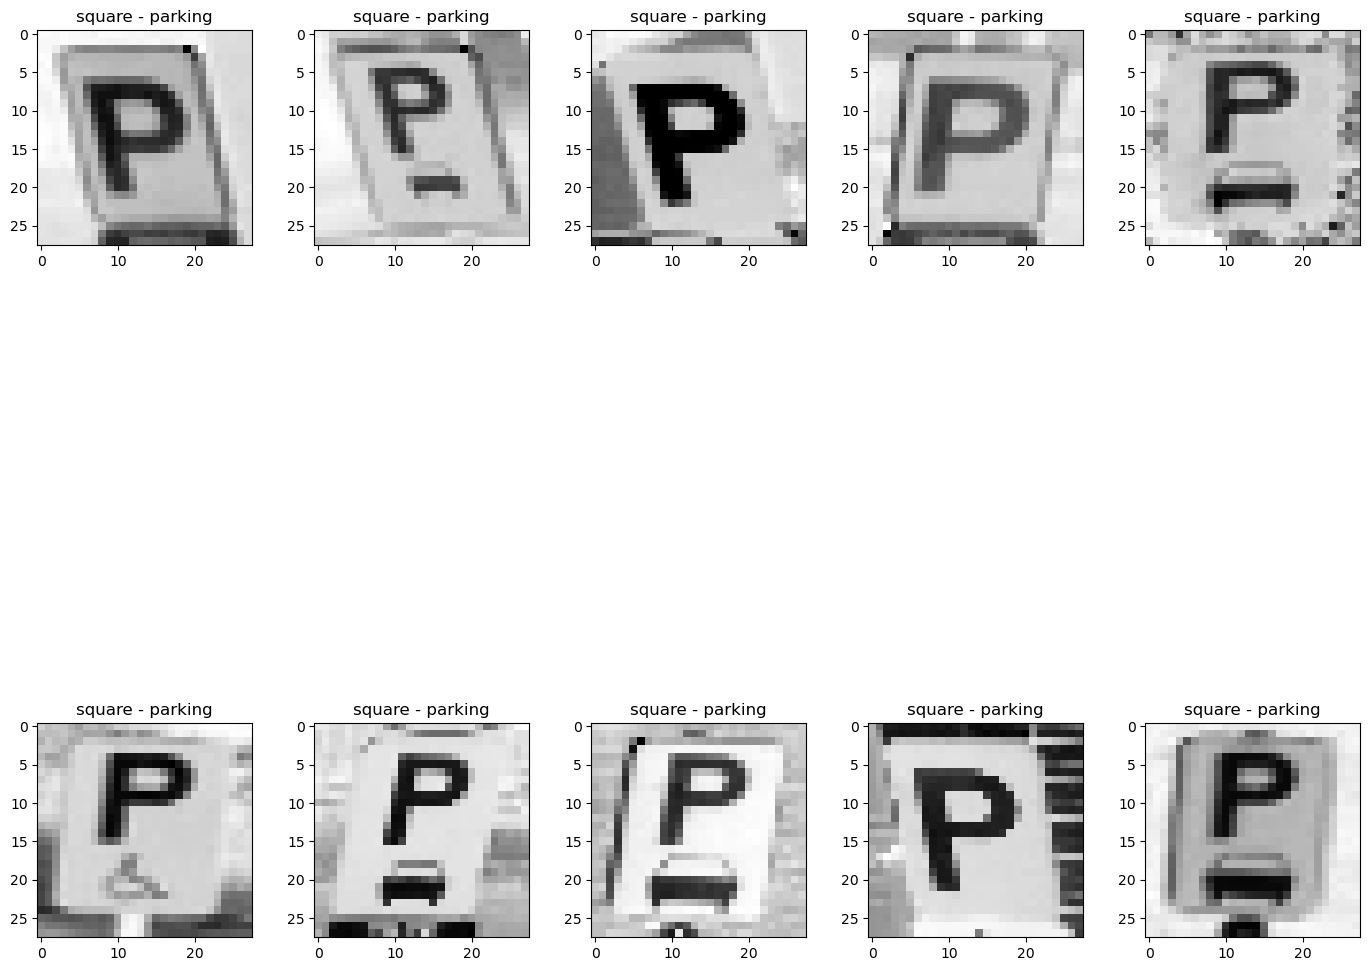

In [32]:
sample_by_signtype('parking', 10, 2)

Sampling with seed 850691377


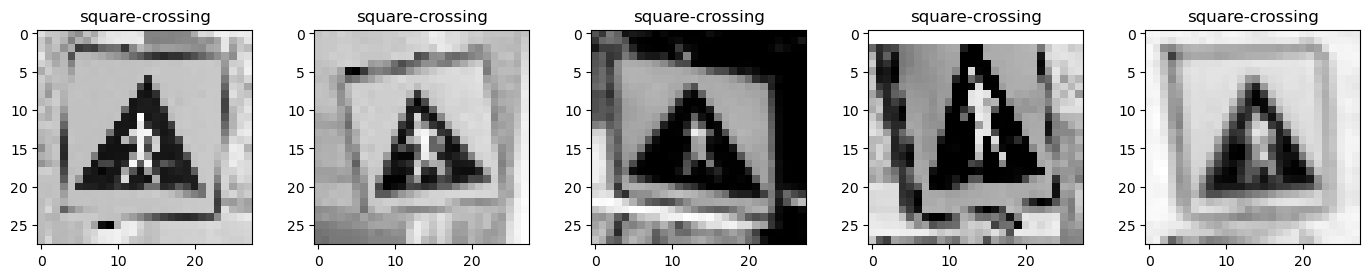

In [33]:
sample_by_signtype('crossing', 5)

Sampling with seed 224858161


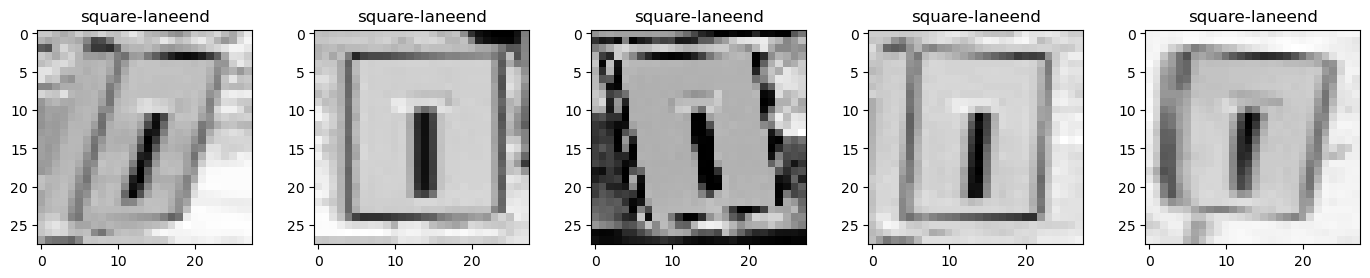

In [34]:
sample_by_signtype('laneend')

Sampling with seed 970893500


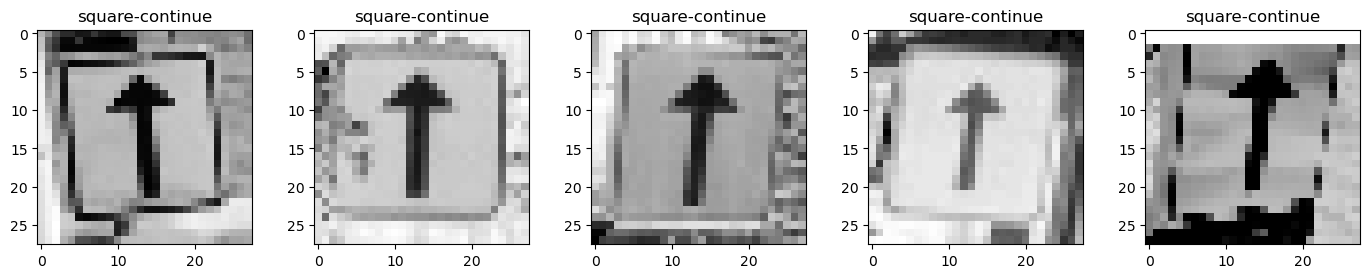

In [35]:
sample_by_signtype('continue')


Observations: 
* Parking signs feature a large white "P" against a dark background.
    * Below the "P" is usually another symbol, denoting what type of parking
        *  Handicap symbol for disabled parking
        * Car symbol for something else (need to look into the german traffic signs data)
* Crossing signs feature a dark-coloured person in a light-coloured triangle, walking to the left.
* Most Square signs have a light outline/border
* Lane end signs feature a white vertical line intersected by dark horizontal line.
 * They meet to make a "T" shape. 
* Continue signs feature a white arrow pointing upwards.
    * Similarities between "continue" and "laneend" could lead to mixed predictions.   

In [36]:
def calc_shape_stats(shape, stat='mean'):
    return calc_stats('shape', shape, stat)


def calc_signtype_stats(signtype, stat='mean'):
    return calc_stats('type', signtype, stat)


def calc_stats(query_col, col_val, stat='mean'):
    img_matrix = None
    stat_img = None
    df = traffic_df.query(f'{query_col} == "{col_val}"')

    for idx, row in df.iterrows():
        row_img = [row['img'].ravel()]
        if img_matrix is None:
            img_matrix = row_img
        else:
            img_matrix = np.vstack((img_matrix, row_img))
    if stat == 'mean':
        stat_img = np.mean(img_matrix, axis=0)
    elif stat == 'median':
        stat_img = np.median(img_matrix, axis=0)
    elif stat == 'std':
        stat_img = np.std(img_matrix, axis=0)
    stat_img = stat_img.reshape((28, 28))
    return stat_img


In [37]:
def mean_shape_img(shape):
    img_matrix = None
    df = traffic_df.query(f'shape == "{shape}"')

    for idx, row in df.iterrows():
        row_img = [row['img'].ravel()]
        if img_matrix is None:
            img_matrix = row_img
        else:
            img_matrix = np.vstack((img_matrix, row_img))
    mean_img = np.mean(img_matrix, axis=0)
    mean_img = mean_img.reshape((28, 28))
    return mean_img

In [38]:
def plot_shape_mean_img(shape):
    plt.imshow(calc_shape_stats(shape), cmap='binary')
    plt.title(f'shape={shape} - mean')
    plt.show()


def plot_signtype_img_stat(signtype, stat='mean'):
    plt.imshow(calc_signtype_stats(signtype, stat), cmap='binary')
    plt.title(f'signtype={signtype} - {stat}')
    plt.show()


def plot_shape_img_stat(shape, stat='mean'):
    plt.imshow(calc_shape_stats(shape, stat), cmap='binary')
    plt.title(f'shape={shape} - {stat}')
    plt.show()


def plot_all_shapes_mean_img():
    for shape in shapes:
        plot_shape_mean_img(shape)

In [39]:
def plot_stat_imgs_for_shape(shape):
    plot_shape_img_stat(shape)
    plot_shape_img_stat(shape, stat='median')
    plot_shape_img_stat(shape, stat='std')


def plot_stat_imgs_for_signtype(signtype):
    plot_signtype_img_stat(signtype)
    plot_signtype_img_stat(signtype, 'median')
    plot_signtype_img_stat(signtype, 'std')

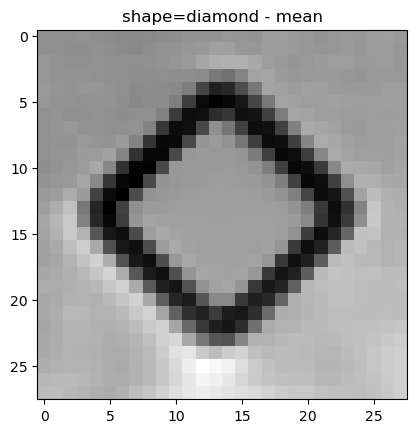

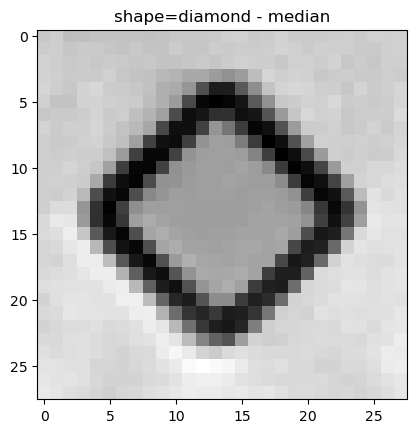

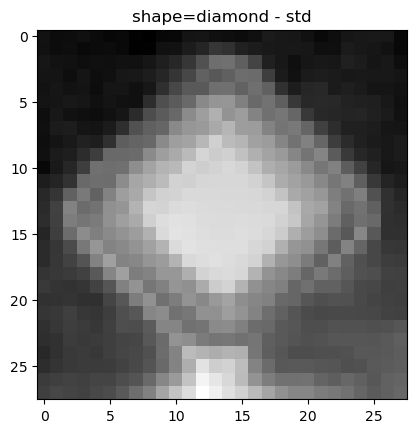

In [40]:
plot_stat_imgs_for_shape('diamond')

Observations: 
* The mean diamond image features a light-coloured background 
* The median diamond is set against a dark background
* Most images of diamonds in our dataset are taken from a front-facing position
    * This could make it more difficult for our model to identify diamonds from other angles
        * We should use image transformations (rotation, zoom, etc.) to help the model generalise to diamonds
* The standard deivation image shows us where there is high variablity in our dataset
    * The edges of the diamond are lighter coloured -- values closer to 1
        * There is higher variability in the pixels around this area.
    * The dark coloured centre tells us that the position of the central is highly concentrated to the centre of the image
        * The lack of variability will impact the model's performance on images outside the dataset. We should fix this with transformations


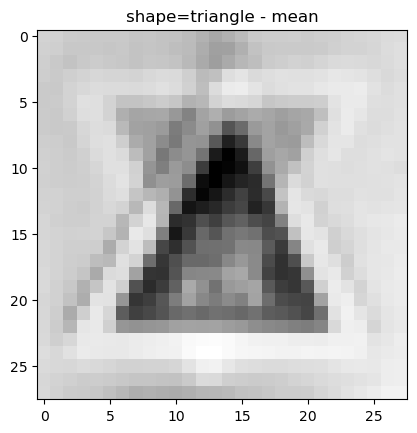

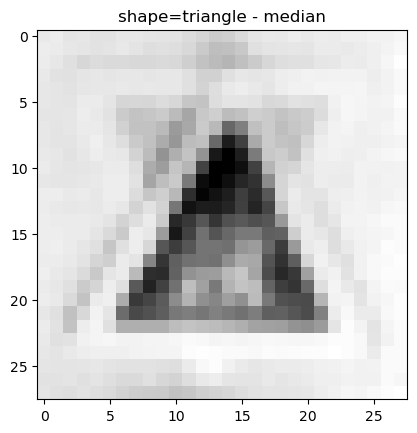

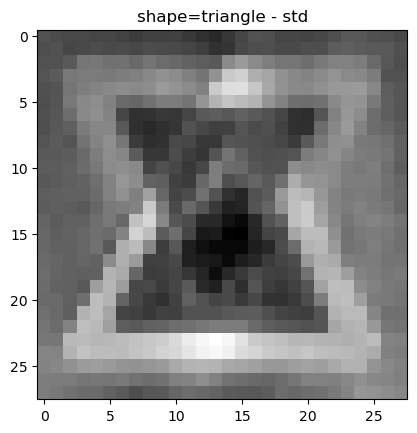

In [41]:
plot_stat_imgs_for_shape('triangle')

Observations: 
* Mean & Median images are similar
* The pole itself doesn't seem to register in the mean and median images. 
* We can see the giveway triangles appear feint in the median & mean, highlighting the class imbalances
* A small shape can be made out in the median & mean images 
* The standard deviation image tells us a few things: 
    * There is a lot of variability in giveway images, given the points there are lighter.
    *  Warning signs do not differ much in terms of their shape (characterised by the dark triangular outline) 
    * The centre of the triangle and the background vary greatly across images. 

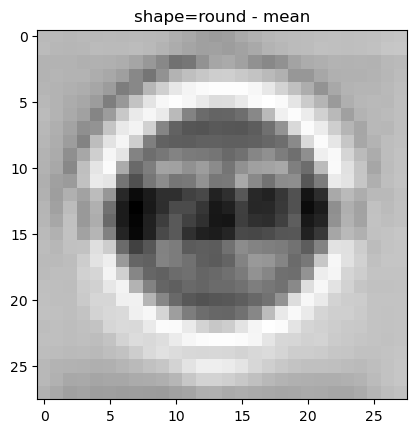

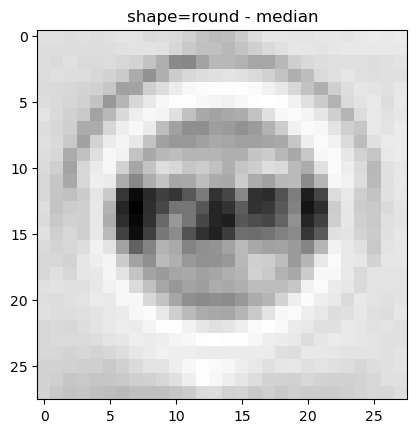

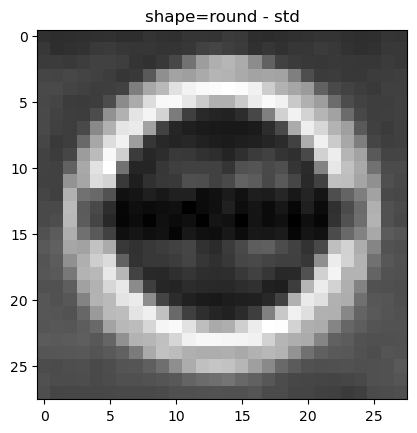

In [42]:
plot_stat_imgs_for_shape('round')

Observations: 
* Mean image indicates a high prevelance of speed signs in the round shape
    * Most prominent speed sign is for the number 70
* The no entry sign's white bar is very prominent across the mean, median, and STD images.
* Other round sign types do not appear. 
    * No sign of the roundabout, bicycle, limitedtraffic, types either.
    * highlights the class imbalances
* The lack of other round types would pose a problem for a model trained to identify both features (shape & sign type)
    * This model's weights would be optimised for both shape & sign type output, leading to deficient performance in the sign type. 
    * A better approach would be to make two models: one for the shape, one for the sign type. 
        * Two separate models means that each model can tune its weights specifically for the task it is working on. 
     

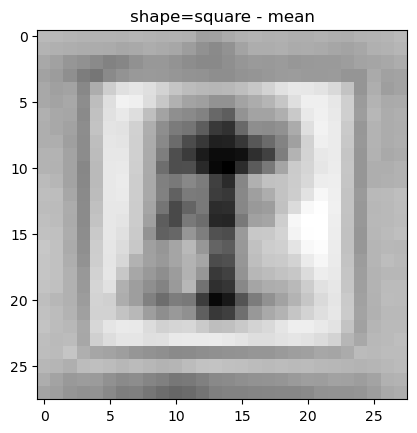

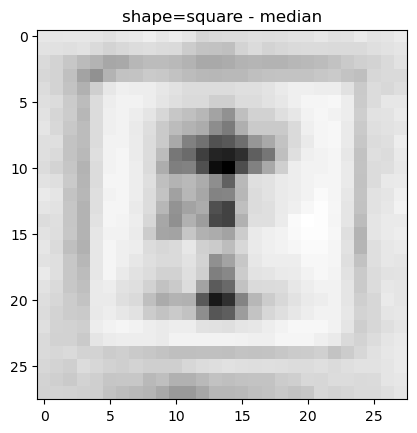

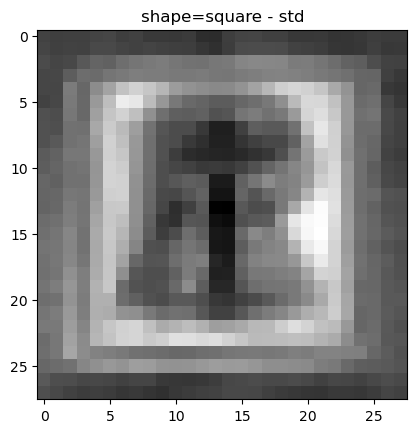

In [43]:
plot_stat_imgs_for_shape('square')

Observations: 
* Square images seem to be represented near-equally in the dataset
* We can see the parking, crossing, and various other types in the images above.
    * This aligns with the frequency analysis we performed earlier -- there is very little class imbalance between thge square sign types. 

Let's do the same for the sign type

In [44]:
print(sign_types, len(sign_types))

['rightofway' 'stop' 'limitedtraffic' 'noentry' 'bicycle' 'roundabout'
 'speed' 'traveldirection' 'trafficdirective' 'noparking' 'laneend'
 'parking' 'continue' 'crossing' 'warning' 'giveway'] 16


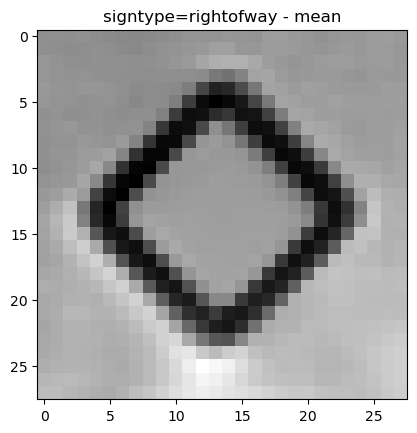

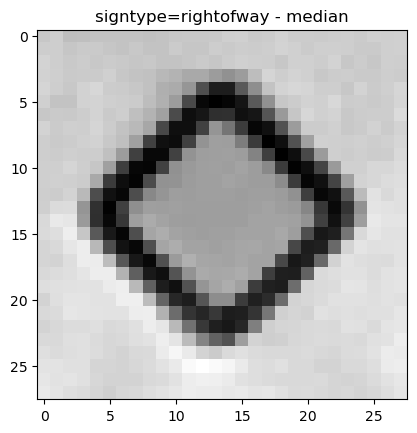

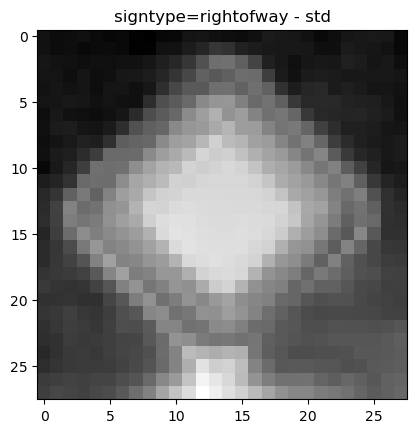

In [45]:
plot_stat_imgs_for_signtype('rightofway')

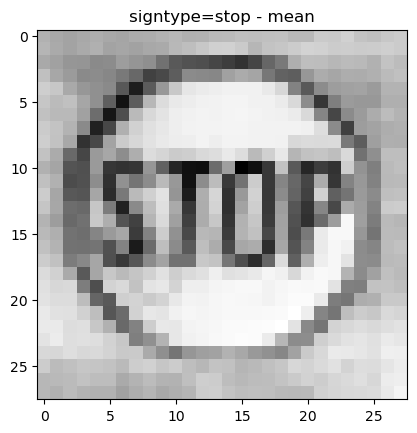

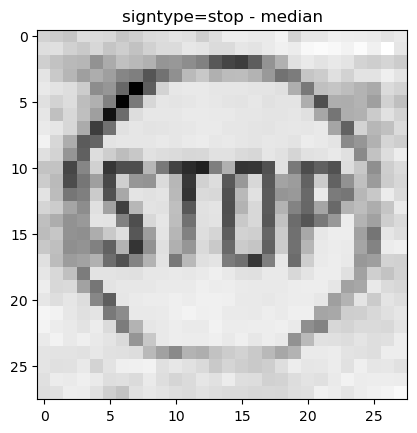

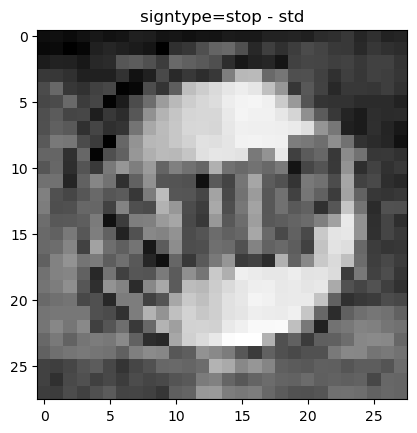

In [46]:
plot_stat_imgs_for_signtype('stop')

Observations: 
* Stop signs are highly variant around the "S". This tells us that there are many instances of "S" being viewed from different angles. 

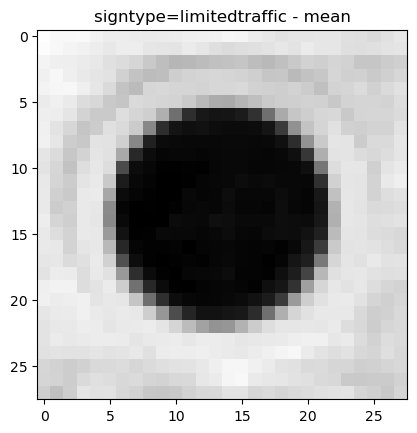

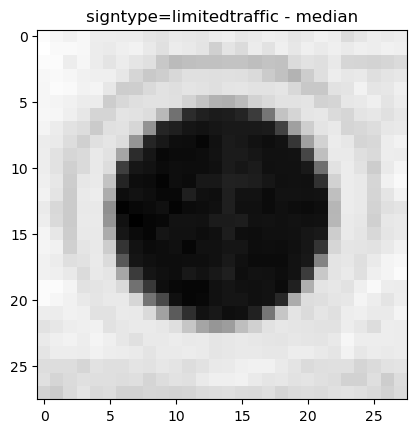

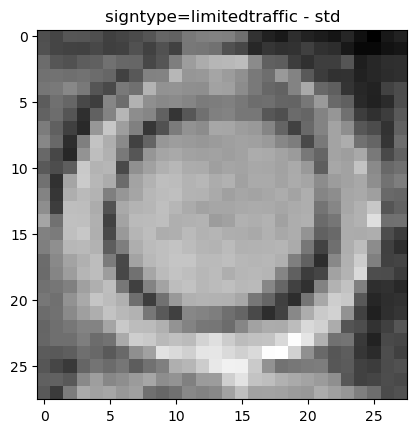

In [47]:
plot_stat_imgs_for_signtype('limitedtraffic')

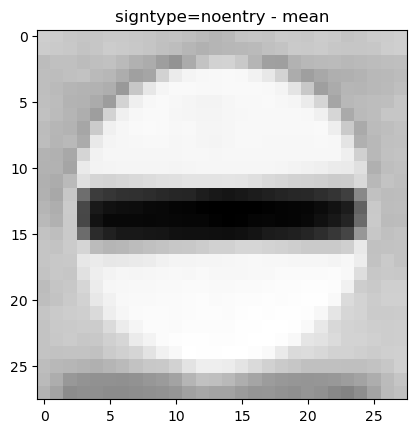

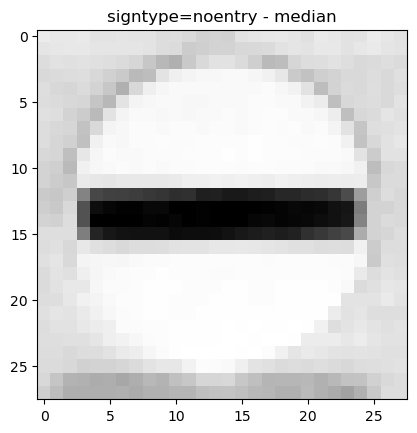

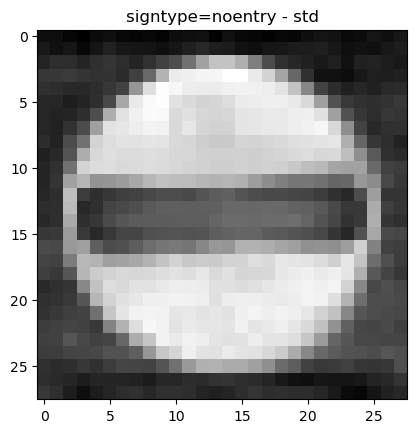

In [48]:
plot_stat_imgs_for_signtype('noentry')

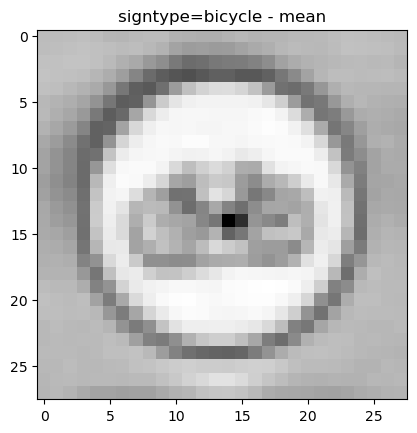

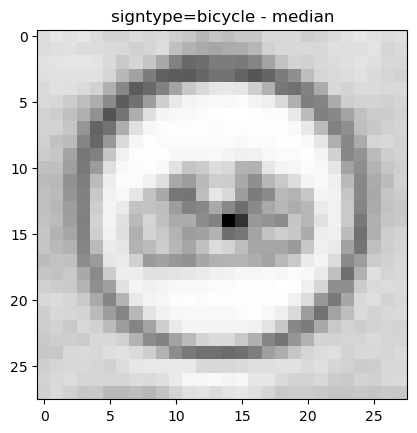

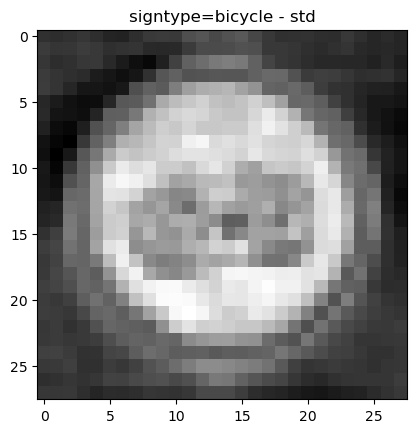

In [49]:
plot_stat_imgs_for_signtype('bicycle')

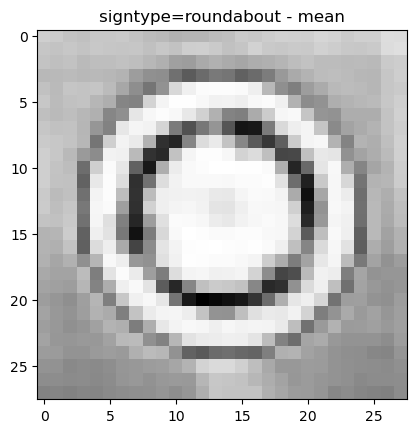

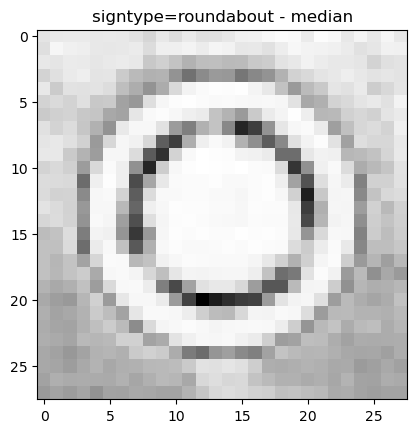

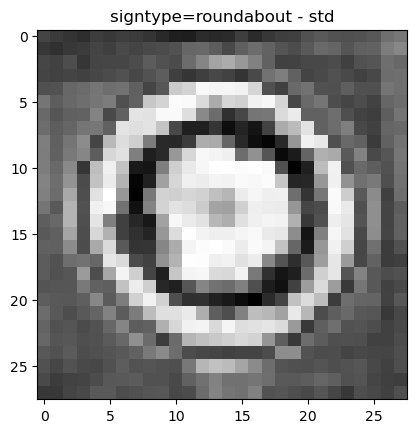

In [50]:
plot_stat_imgs_for_signtype('roundabout')

Let's summariese our findings: 
* Round shapes are the most feature in the dataset
* Warning is the most common sign type in the dataset
* Many round sign types are under-represented in the dataset

## Model Development
As a baseline, we'll build two MLP models trained on augmented features of the dataset. 
The augmentations that I think should be applied are: 
    * Zoom
    * Rotate
    * Flip
    * Brightness adjust
    
I've chosen these augmentations because NNs are prone to overfitting their dataset, augmentations help reduce some of this by providing unique samples not present in the existing dataset. 
Both models will have the same architecture for simplicity. 

We're aiming for a F1 as it is the harmonic mean of Precision & Recall. The target F1 is 80%.

In [51]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, RandomRotation, \
    RandomFlip, RandomTranslation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.metrics import F1Score
from keras.utils import plot_model
from keras.models import Model
from sklearn.model_selection import train_test_split

/home/itsthatblackkid/miniforge3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [97]:
def load_and_split_dataset(train_size=0.8, random_state=42, y='shape'):
    dataset = load_dataset()
    for index, row in dataset.iterrows():
        img = row['img']
        img = np.reshape(img, 28 * 28)
        row['img'] = img / 255.0
    return train_test_split(dataset, train_size=train_size, random_state=random_state)

In [53]:
# constants we will use for training the NNs
input_shape = (28, 28, 1)
batch_size = 32

In [54]:
def create_baseline_mlp(is_sign_type=False):
    model_input = Input(input_shape)
    x = RandomFlip()(model_input)
    x = Flatten()(model_input)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = len(sign_types) if is_sign_type else len(shapes)
    name = 'sign_type' if is_sign_type else 'shape'
    x = Dense(outputs, activation='softmax', name=name)(x)
    model = Model(inputs=model_input, outputs=x)
    print(model.summary())
    return model

In [55]:
def get_target_feature_dummies(target='shape'):
    return pd.get_dummies(traffic_df[target])

In [56]:
sign_type_baseline = create_baseline_mlp(True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 sign_type (Dense)           (None, 16)                1040      
                                                                 
Total params: 476880 (1.82 MB)
Trainable params: 476880 (1.82

In [57]:
sign_type_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
X = []
for index, row in traffic_df.iterrows():
    img = row['img']
    img = np.reshape(img, 28 * 28)
    X.append(img)
X = np.array(X)
X.shape

(3699, 784)

In [59]:
X = X.reshape(len(X), 28, 28, 1) / 255
X.shape

(3699, 28, 28, 1)

In [60]:
X_train = X[:int(len(X) * 0.75)]
X_test = X[int(len(X) * 0.75):]
print(X_train.shape, X_test.shape)

(2774, 28, 28, 1) (925, 28, 28, 1)


In [61]:
print(len(X_train), len(X_test))

2774 925


In [62]:
sign_type_y = pd.get_dummies(traffic_df['type'])
sign_type_y_train = sign_type_y[:int(len(sign_type_y) * 0.75)]
sign_type_y_test = sign_type_y[int(len(sign_type_y) * 0.75):]
print(sign_type_y_train.shape, sign_type_y_test.shape)
print(len(sign_type_y_train), len(sign_type_y_test))

(2774, 16) (925, 16)
2774 925


In [63]:
history = sign_type_baseline.fit(X_train, sign_type_y_train, epochs=40, validation_data=(X_test, sign_type_y_test))

Epoch 1/40
87/87 [==============================] - 0s 2ms/step - loss: 1.4916 - accuracy: 0.5919 - val_loss: 10.1283 - val_accuracy: 0.0000e+00
Epoch 2/40
87/87 [==============================] - 0s 1ms/step - loss: 0.6753 - accuracy: 0.8216 - val_loss: 13.4713 - val_accuracy: 0.0000e+00
Epoch 3/40
87/87 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.8886 - val_loss: 12.5688 - val_accuracy: 0.0000e+00
Epoch 4/40
87/87 [==============================] - 0s 1ms/step - loss: 0.3160 - accuracy: 0.9211 - val_loss: 14.1935 - val_accuracy: 0.0000e+00
Epoch 5/40
87/87 [==============================] - 0s 1ms/step - loss: 0.3330 - accuracy: 0.9048 - val_loss: 13.9727 - val_accuracy: 0.0000e+00
Epoch 6/40
87/87 [==============================] - 0s 1ms/step - loss: 0.2165 - accuracy: 0.9391 - val_loss: 13.5575 - val_accuracy: 0.0000e+00
Epoch 7/40
87/87 [==============================] - 0s 1ms/step - loss: 0.2046 - accuracy: 0.9394 - val_loss: 12.8175 - val_accura

In [64]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

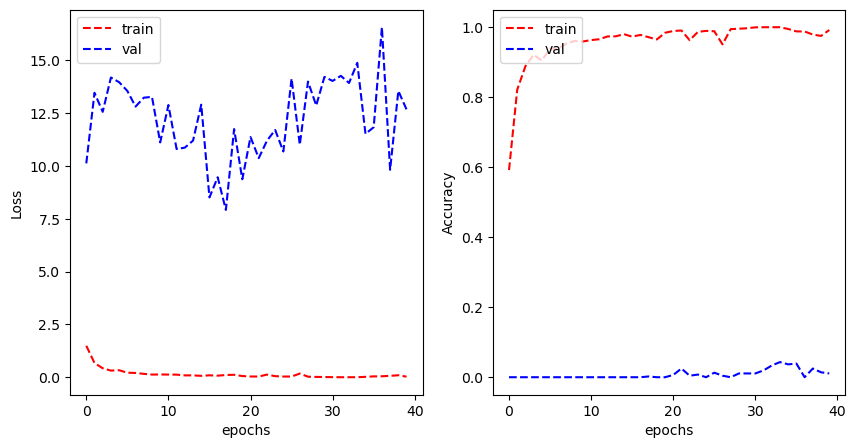

In [65]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['accuracy'],
                    history.history['val_accuracy'], )

Observations: 
* The MLP struggles to fit a to the structured image dataset, without any augmentations. 
* Augmentations may not improve performance much, given MLPs are not good at fitting images.

In [92]:
def create_sign_type_mlp_aug(is_sign_type=False):
    m_input = Input((28,28,1))
    x = RandomFlip()(m_input)
    x = RandomRotation(180)(x)
    x = RandomTranslation((-0.2, 0.5), (-0.2, 0.5))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = len(sign_types) if is_sign_type else len(shapes)
    name = 'sign_type' if is_sign_type else 'shape'
    x = Dense(outputs, activation='softmax', name=name)(x)
    model = Model(inputs=m_input, outputs=x)
    print(model.summary())
    return model

Justifications: 
* RandomFlip transformations augment our input by flipping it alon the x-axis.
    * Provides a different example each epoch, to help reduce overfitting to one example
* RandomRotation by 180 degrees because many images are from the right side up  

In [88]:
train, test = load_and_split_dataset(train_size=0.75, random_state=42)

Loading diamond...
diamond images loaded
Loading hex...
hex images loaded
Loading round...
round images loaded
Loading square...
square images loaded
Loading triangle...
triangle images loaded


In [98]:
def get_X_y(train: pd.Series, test: pd.Series, is_sign_type=False):
    X_train = train['img'].to_numpy().reshape(len(train), 28, 28,1)
    y_train = pd.get_dummies(train['type']) if is_sign_type else pd.get_dummies(train['shape'])
    
    X_test = test['img'].to_numpy().reshape(len(test), 28, 28,1)
    y_test = pd.get_dummies(test['type']) if is_sign_type else pd.get_dummies(test['shape'])
    
    return X_train, y_train, X_test, y_test

In [99]:
X_train, y_train, X_test, y_test = get_X_y(train, test, is_sign_type=True)

ValueError: cannot reshape array of size 2774 into shape (2774,28,28,1)

In [93]:
sign_type_mlp_baseline_aug = create_sign_type_mlp_aug(True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_3 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 random_translation_1 (Rand  (None, 28, 28, 1)         0         
 omTranslation)                                                  
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               4019

In [94]:
sign_type_mlp_baseline_aug.compile(optimizer='adam', loss='categorical_crossentropy',
                                   metrics=[F1Score(num_classes=len(sign_types))])

In [96]:
sign_type_mlp_baseline_aug.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=40)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).